In [20]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
from tqdm import tqdm

import torch.nn.init as init
from torch.nn.parameter import Parameter
from sklearn.model_selection import train_test_split
from collections import namedtuple
from multiprocessing import Pool
from collections import deque

In [21]:
class NeuralAccumulatorCell(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.W_hat, a=math.sqrt(5))
        init.kaiming_uniform_(self.M_hat, a=math.sqrt(5))

    def forward(self, input):        
        W = torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat)
        return F.linear(input, W, self.bias)



class NAC(nn.Module):
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.preprocess = Net()

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralAccumulatorCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.preprocess(x)
        out = self.model(x)
        return out.squeeze(1).T

class NeuralArithmeticLogicUnitCell(nn.Module):
 
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.G, a=math.sqrt(5))

    def forward(self, input):
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y

class NALU(nn.Module):
   
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.preprocess = Net()

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralArithmeticLogicUnitCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.preprocess(x)
        out = self.model(x)
        return out.squeeze(1).T
    



In [22]:
N_numbers = 10

In [23]:
transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [24]:
class Dataset:
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
def splitting_data(train_data):
    X, y = [], []
    inps, labs = [], []
    for inputs, labels in train_data:
        labs.append(labels)
        inps.append(inputs)
        if len(labs) % N_numbers == 0:
            X.append(torch.cat(inps, dim=1).unsqueeze(0))
            y.append(sum(labs))
            inps, labs = [], []
    return torch.cat(X), y

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.preprocess = nn.Sequential(nn.Conv2d(1, 10, kernel_size=5), 
                                        nn.MaxPool2d(2), 
                                        nn.ReLU(), 
                                        nn.Conv2d(10, 20, kernel_size=5), 
                                        nn.Dropout2d(),
                                        nn.MaxPool2d(2), 
                                        nn.ReLU())
        self.fc1 = nn.Linear(20 * 67 * 4, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, input_x):
        x = self.preprocess(input_x).view(-1, 20 * 67 * 4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [27]:
Activations = {
 'Hardtanh'   : nn.Hardtanh(),
 'Sigmoid'    : nn.Sigmoid(),
 'ReLU6'      : nn.ReLU6(),
 'Tanh'       : nn.Tanh(),
 'Tanhshrink' : nn.Tanhshrink(), 
 'Hardshrink' : nn.Hardshrink(), 
 'LeakyReLU'  : nn.LeakyReLU(), 
 'Softshrink' : nn.Softshrink(),  
 'Softsign'   : nn.Softsign(),
 'ReLU'       : nn.ReLU(),
 'PReLU'      : nn.PReLU(), 
 'Softplus'   : nn.Softplus(), 
 'ELU'        : nn.ELU(),
 'SELU'       : nn.SELU(),
 'None'       : None  
}




class MLP(nn.Module):
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim, activation='relu'):
        super().__init__()
        self.preprocess = Net()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.activation = Activations[activation]

        nonlin = True
        if self.activation is None:
            nonlin = False

        layers = []
        for i in range(num_layers - 1):
            layers.extend(
                self._layer(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim,
                    nonlin,
                )
            )
        layers.extend(self._layer(hidden_dim, out_dim, False))

        self.model = nn.Sequential(*layers)
        
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(m.bias, -bound, bound)

    def _layer(self, in_dim, out_dim, activation=True):
        if activation:
            return [
                nn.Linear(in_dim, out_dim),
                self.activation,
            ]
        else:
            return [
                nn.Linear(in_dim, out_dim),
            ]

    def forward(self, x):
        x = self.preprocess(x)
        out = self.model(x)
        return out.squeeze(1).T

In [28]:
Func = 'ADD'
ADD  = lambda x: np.sum(x)

STATE = {
    'ADD' : {
        'EPOCHS'      : 15,
        'BATCH_SIZE'  : 1000,
        'LAYERS'      : 4,
        'HIDDEN'      : 5,
    },
    
    'PROD' : {
        'EPOCHS'      : 10000,
        'BATCH_SIZE'  : 10000,
        'LAYERS'      : 2,
        'HIDDEN'      : 10,
    }
}

In [29]:
X_train, y_train = splitting_data(train_data)
data_train = Dataset(X_train, y_train)

X_test, y_test = splitting_data(test_data)
data_test = Dataset(X_test, y_test)

In [36]:
def f(par, model_type = 'NAC'):    
    def tester(model):
        mae = 0.0
        for inputs, labels in TestSet:
                outputs = model(inputs)
                mae += torch.mean(torch.abs(labels - outputs))
        return mae.item()
    
    TrainSet = DataLoader(data_train, batch_size=STATE[Func]['BATCH_SIZE'], shuffle=True)
    TestSet = DataLoader(data_test, batch_size=STATE[Func]['BATCH_SIZE'], shuffle=True)
    
    if model_type == 'NAC':
        Model = NAC(num_layers=par,
                in_dim=10,
                hidden_dim=16,
                out_dim=1)
    elif model_type == 'NALU':
        Model = NALU(num_layers=STATE[Func]['LAYERS'],
                in_dim=10,
                hidden_dim=par,
                out_dim=1)
    elif model_type == 'MLP':
        Model = MLP(num_layers=STATE[Func]['LAYERS'],
                in_dim=N_numbers,
                hidden_dim=STATE[Func]['HIDDEN'],
                out_dim=1,
                activation=par)
         
    optim = torch.optim.RMSprop(Model.parameters(), lr=1e-2)
    LOSS = []
    for epoch in tqdm(range(STATE[Func]['EPOCHS']), position = 0, leave = False):  
        epoch_mse_loss = 0.0
        epoch_mae_loss = 0.0
        for inputs, labels in TrainSet:
            outputs = Model(inputs)

            optim.zero_grad()
            loss = F.mse_loss(outputs, labels)
            mae = torch.mean(torch.abs(labels - outputs)).item()
            loss.backward()
            optim.step()

            epoch_mse_loss += loss.item() 
            epoch_mae_loss += mae
        LOSS.append(epoch_mae_loss)
    
    mae = 0.0
    for inputs, labels in TestSet:
        outputs = Model(inputs)
        mae += torch.mean(torch.abs(labels - outputs))
        
    return LOSS + [par] + [tester(Model)]

In [19]:
%%time
with Pool(4) as p:
    rez = p.map(f, tqdm(list(Activations.keys()), position = 0, leave = False))

CPU times: user 1.34 s, sys: 385 ms, total: 1.73 s
Wall time: 35min 16s


In [37]:
marks = {
 'Hardtanh'   : ['o', 'yellowgreen'],
 'Sigmoid'    : ['v', 'violet'],
 'ReLU6'      : ['^', 'cadetblue'],
 'Tanh'       : ['<', 'firebrick'],
 'Tanhshrink' : ['>', 'mediumvioletred'], 
 'Hardshrink' : ['8', 'lightslategray'], 
 'LeakyReLU'  : ['s', 'darkblue'], 
 'Softshrink' : ['p', 'green'],  
 'Softsign'   : ['*', 'thistle'],
 'ReLU'       : ['h', 'lightpink'],
 'PReLU'      : ['H', 'aquamarine'], 
 'Softplus'   : ['D', 'aqua'], 
 'ELU'        : ['d', 'fuchsia'],
 'SELU'       : ['P', 'dodgerblue'],
 'None'       : ['X', 'red']
}

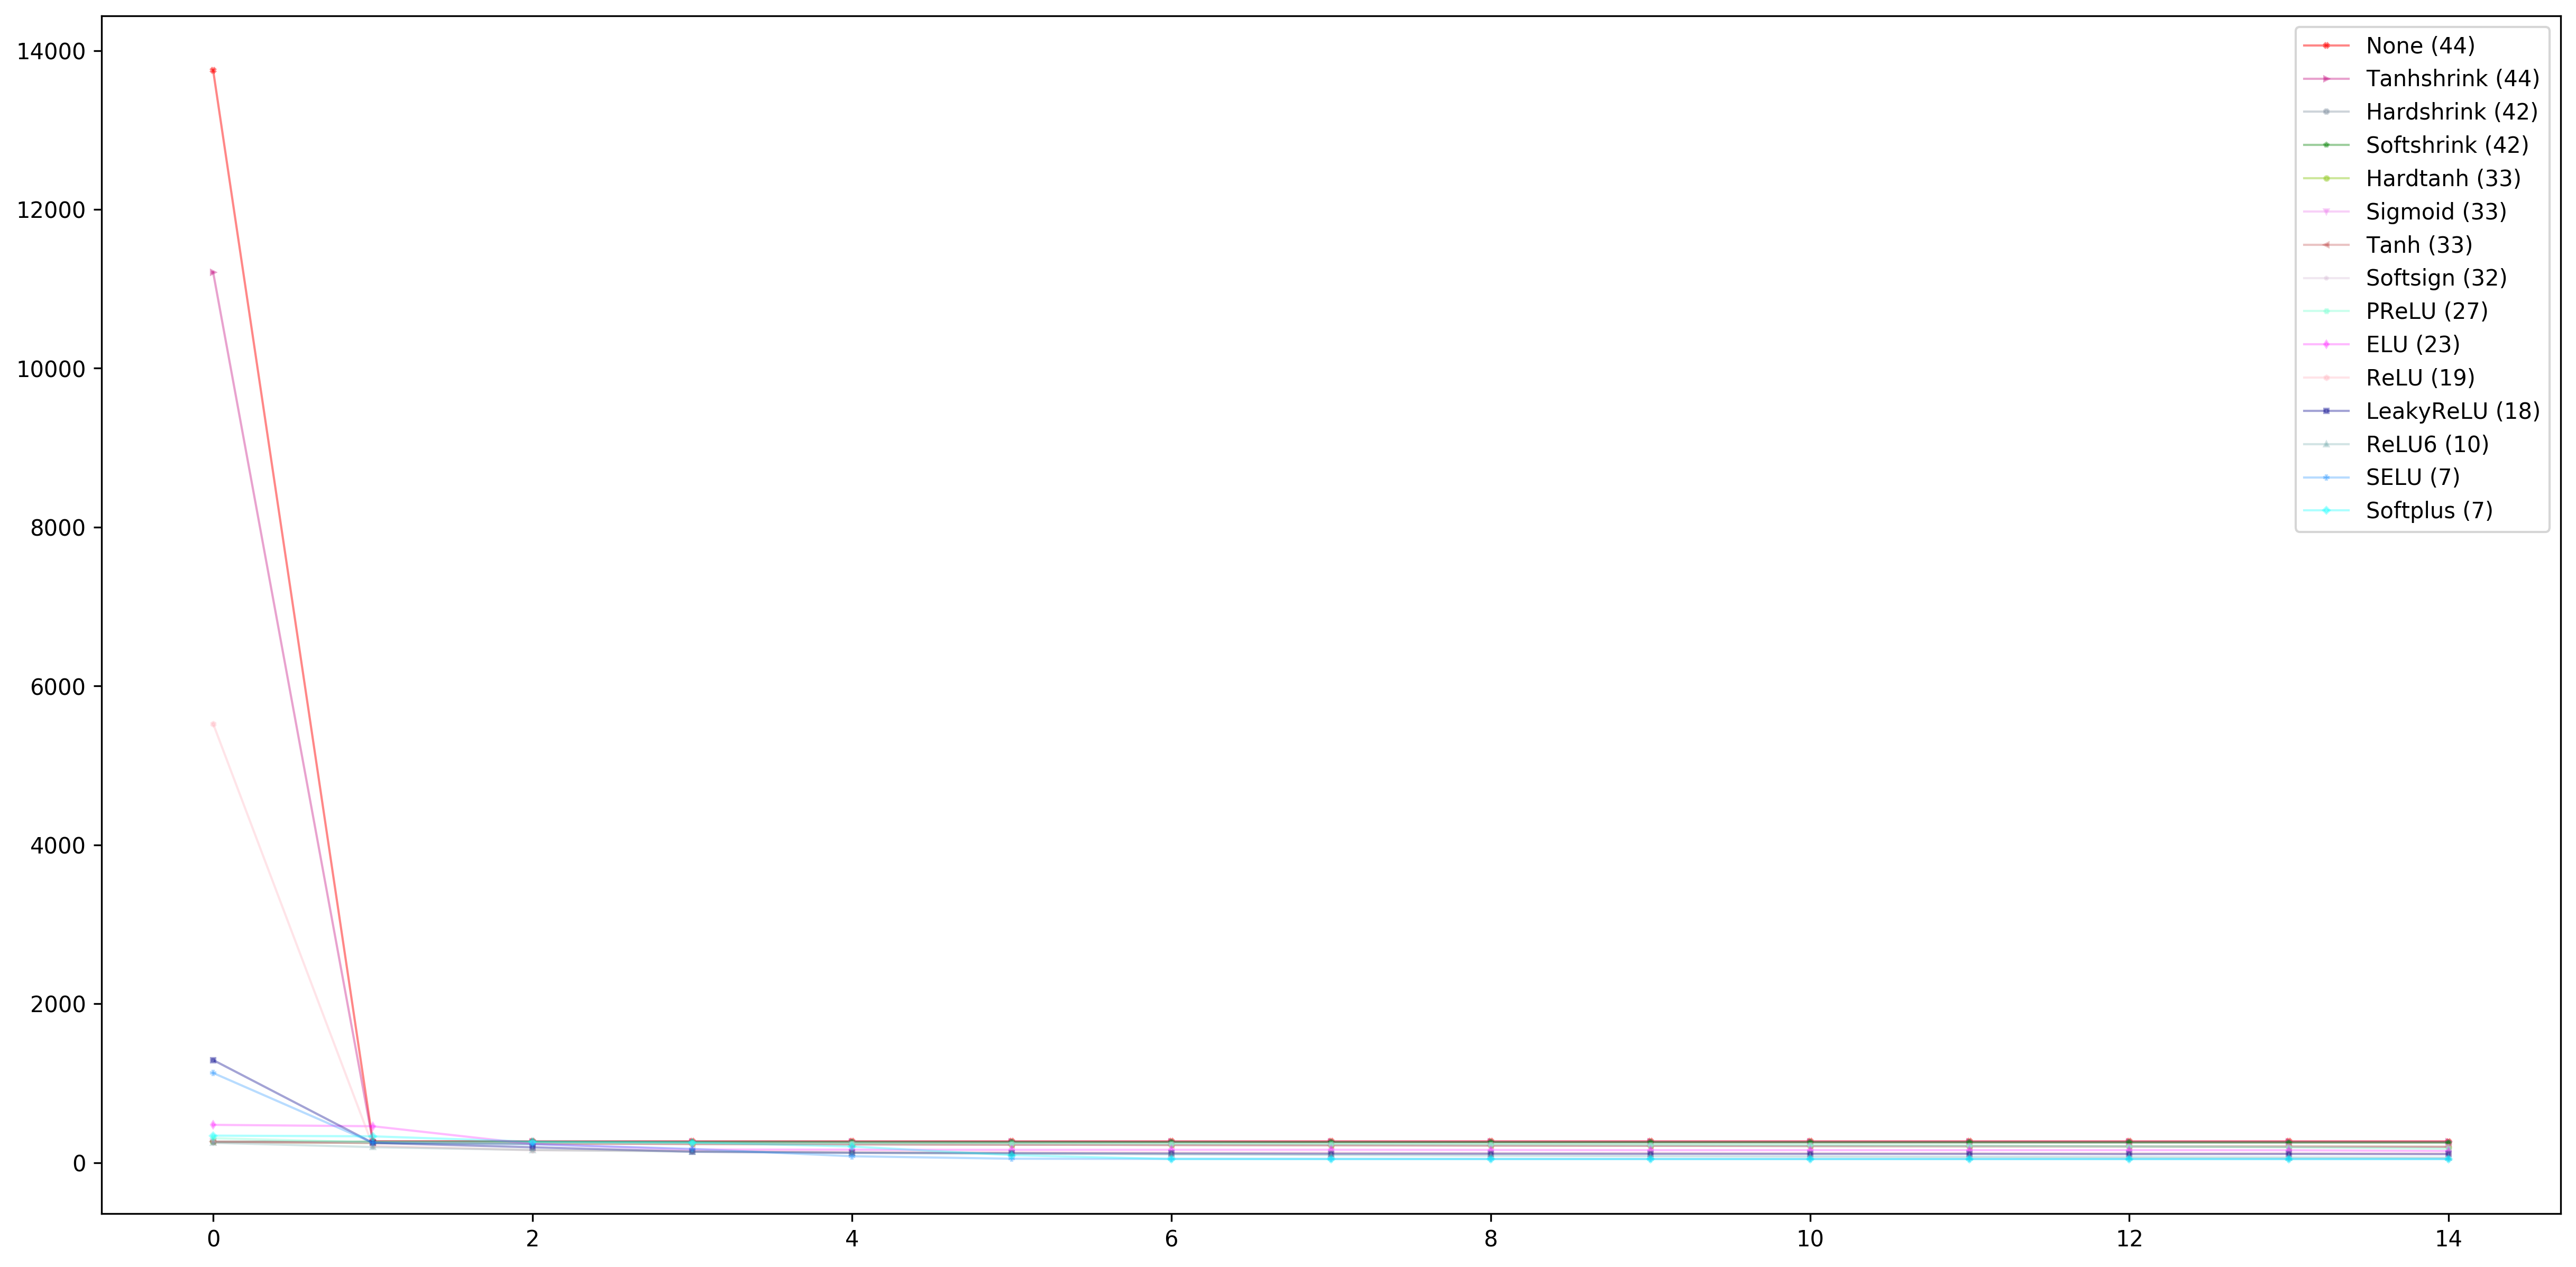

In [22]:
fig = plt.figure(num=None, figsize=(20, 10), dpi=300, facecolor='w', edgecolor='k')
numb = 0
for data in sorted(rez, key = lambda x: x[-3], reverse = True):
    losses, act, test = data[:-2], data[-2], data[-1]
    plt.plot(np.arange(len(losses)), losses, label = f'{act} ({test:.0f})',
             marker = marks[act][0], ms = 2.0, c = marks[act][1],
             alpha = np.random.uniform(0.25, 0.5), lw = 1.0)
    plt.legend()
    numb += 1

In [38]:
%%time
with Pool(4) as p:
    rez = p.map(f, tqdm([2, 4, 6, 8, 10, 12, 14, 16], position = 0, leave = False))

CPU times: user 804 ms, sys: 233 ms, total: 1.04 s
Wall time: 20min 5s


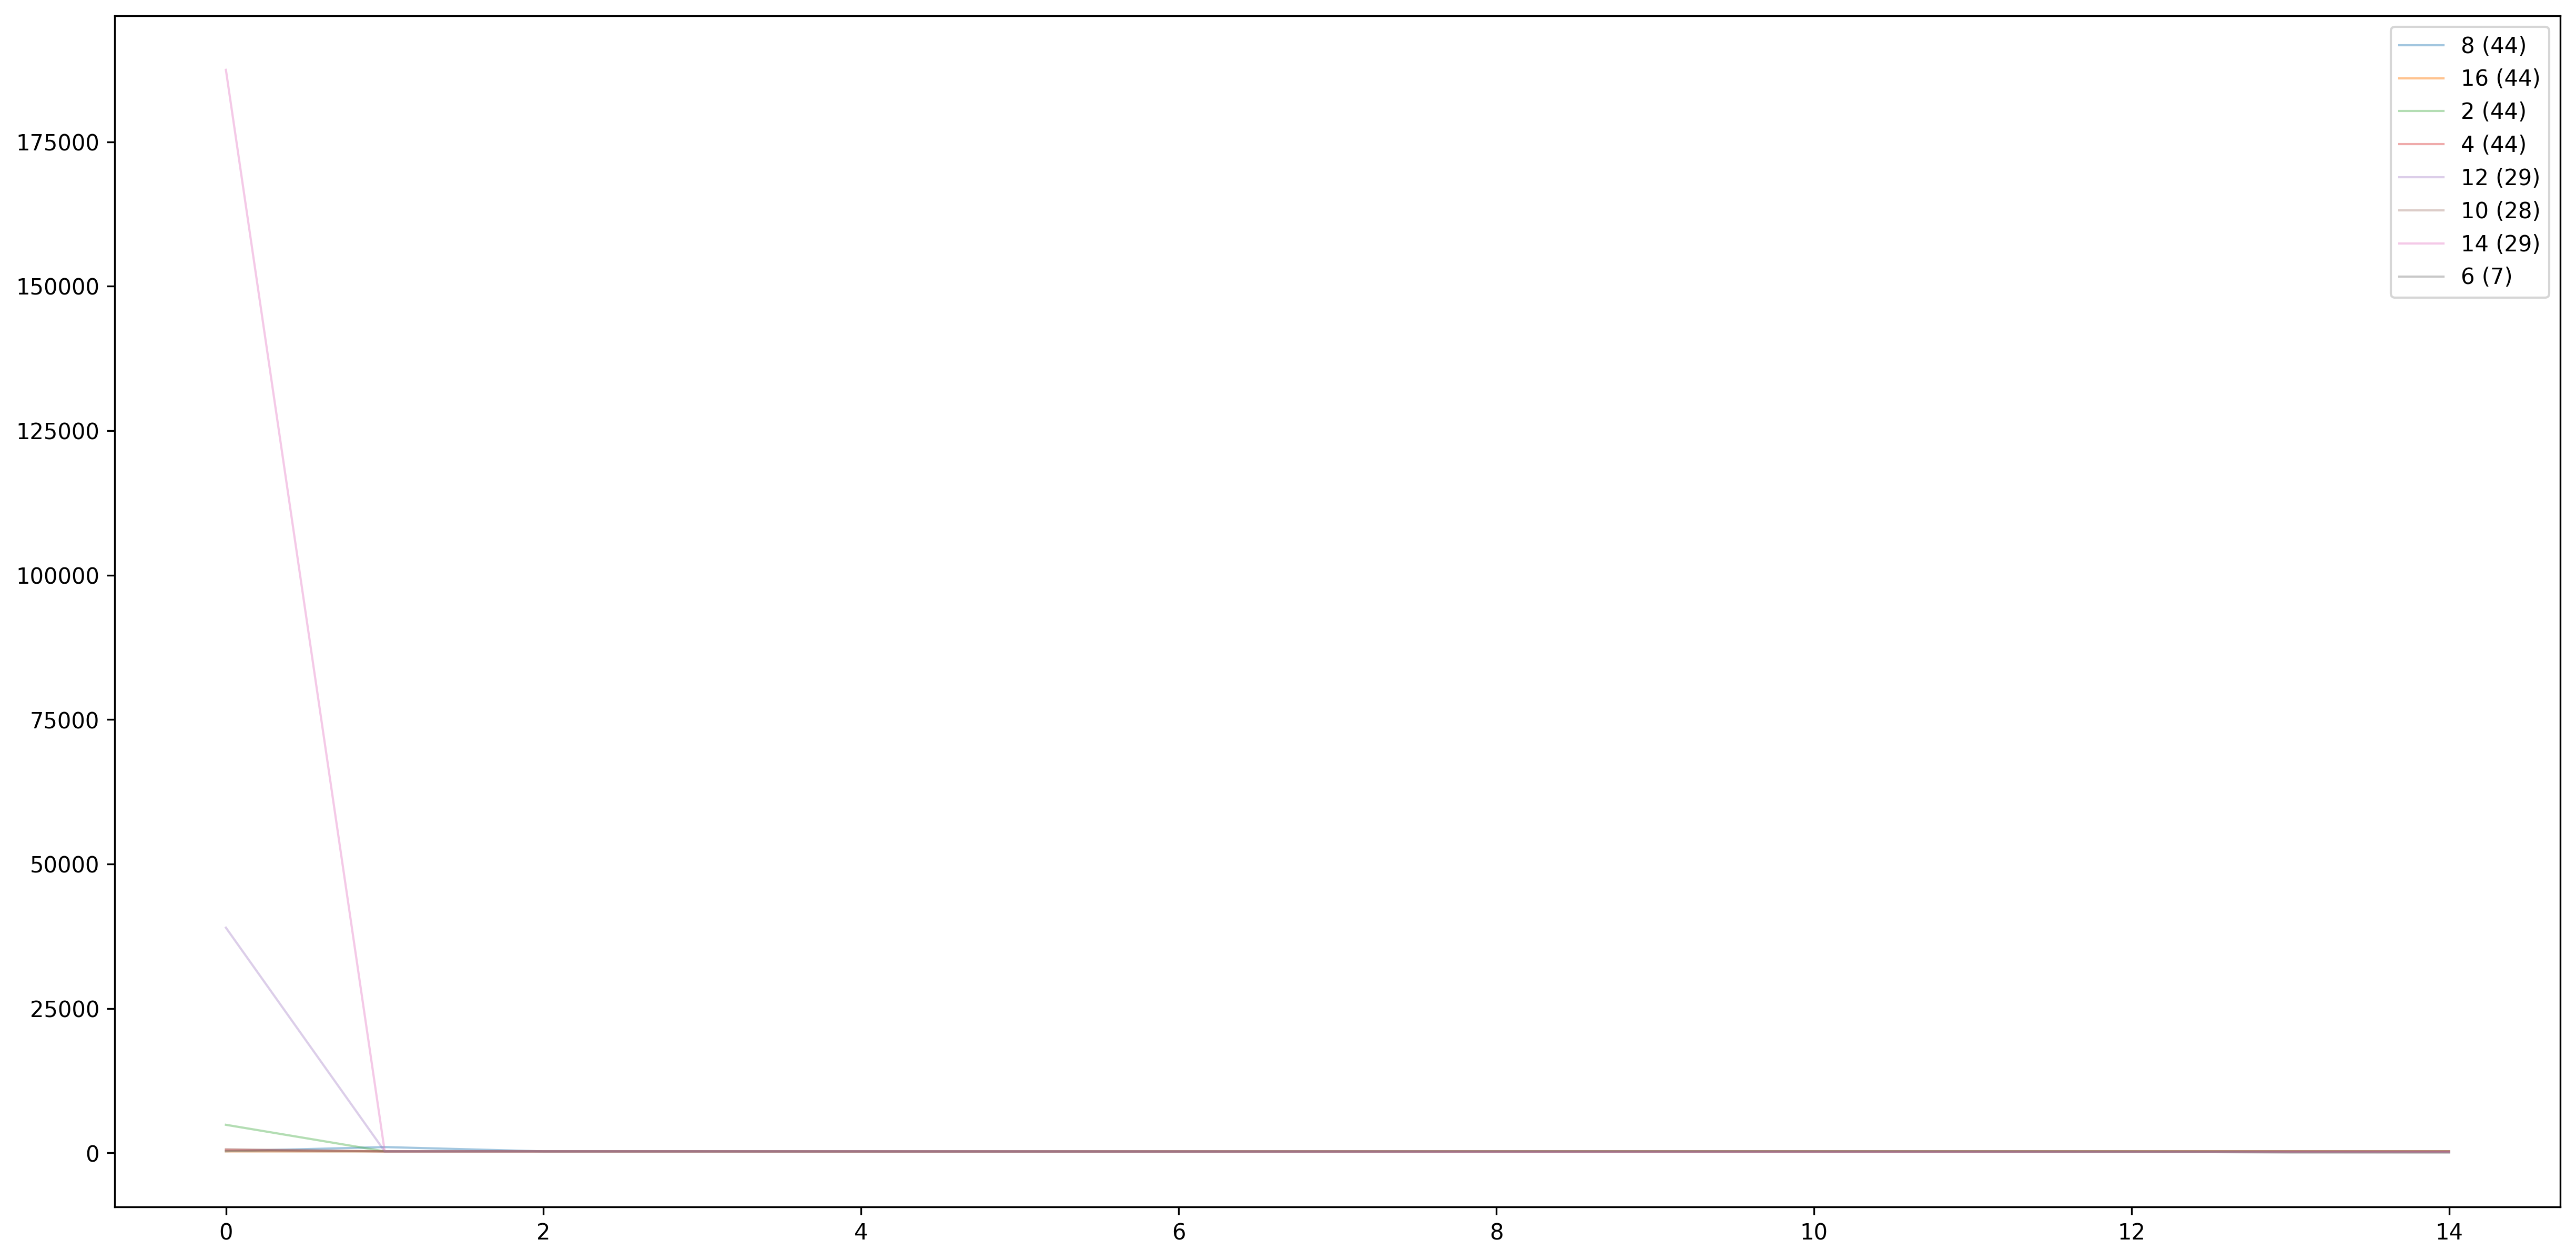

In [39]:
fig = plt.figure(num=None, figsize=(20, 10), dpi=300, facecolor='w', edgecolor='k')
numb = 0
for data in sorted(rez, key = lambda x: x[-3], reverse = True):
    losses, act, test = data[:-2], data[-2], data[-1]
    plt.plot(np.arange(len(losses)), losses, label = f'{act} ({test:.0f})',
             #marker = marks[act][0], ms = 2.0, c = marks[act][1],
             alpha = np.random.uniform(0.25, 0.5), lw = 1.0)
    plt.legend()
    numb += 1
plt.show()